In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from pylab import mpl
import random
import keras
from math import sqrt
import tensorflow as tf
 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from collections import deque
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Dense,LSTM,BatchNormalization,Dropout,SimpleRNN,Activation,Input,Flatten
from tensorflow.keras.layers import Conv2D
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.utils import plot_model
from keras.losses import mape
from keras import optimizers
from scipy.io import loadmat,savemat



import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_excel("横波反演数据.xlsx",sheet_name='yq3')

In [3]:
dataset['RT-电阻率']=np.log10(dataset['RT-电阻率'])

In [4]:
colunms=['CNL-中子','DEN-密度','GR-自然伽马','VP-纵波速度','RT-电阻率']     
scaler=MinMaxScaler()
scaler1=MinMaxScaler()
for col in colunms:
    dataset[col]=scaler.fit_transform(dataset[col].values.reshape(-1,1))
dataset['VS-横波速度']=scaler1.fit_transform(dataset['VS-横波速度'].values.reshape(-1,1))   

In [5]:
x=dataset.loc[:,['CNL-中子','DEN-密度','GR-自然伽马','VP-纵波速度','RT-电阻率']]
y=dataset['VS-横波速度']

In [6]:
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=666,shuffle=False)

In [7]:
def windows(x,y,days):
    features=[]
    targets=[]
    
    x=scaler.fit_transform(x.iloc[:,:])
    deq=deque(maxlen=days)
    for i in x:
        deq.append(list(i))
        if days==len(deq):
            features.append(list(deq))
            
            
    x=features[:]        
    targets=y.values[days-1:]
    
    
    return np.array(x),np.array(targets)

In [8]:
train_dataset,train_labels=windows(X_train,y_train,3)
test_dataset,test_labels=windows(X_test,y_test,3)

In [9]:
train1=np.expand_dims(train_dataset,axis=3)
test1=np.expand_dims(test_dataset,axis=3)

In [10]:
def create_batch_dataset(X, y, train=True, buffer_size=1000, batch_size=128):
    batch_data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    if train: 
        return batch_data.cache().shuffle(buffer_size).batch(batch_size)
    else: 
        return batch_data.batch(batch_size)

In [11]:
train_batch_dataset = create_batch_dataset(train_dataset, train_labels)
test_batch_dataset = create_batch_dataset(test_dataset, test_labels, train=False)

In [12]:
class Attention_Conv2D(keras.layers.Layer):
    def __init__(self, filters=None, num_heads=None, gamma=0.01, activation='relu', return_attention_scores=False, trainable=True):
        super().__init__(trainable=trainable)
        self.gamma = tf.Variable(initial_value=gamma, trainable=True, name='gamma')
        self.f = None
        self.g = None
        self.h = None
        self.v = None
        self.attention = None
        self.num_heads = num_heads
        self.c = filters
        self.activation = activation

    def build(self, input_shape):

        if self.c is None:
            self.c = input_shape[-1]

        if self.num_heads is None:
            self.num_heads = input_shape[-1]

        self.f = self.block(self.num_heads) # [n, w*h, heads]
        self.g = self.block(self.num_heads) # [n, w*h, heads]
        self.h = self.block(self.num_heads) # [n, w*h, heads]

        # output feature maps -> [n, w, h, filters]
        self.v = layers.Conv2D(self.c, 1, 1, activation=self.activation)

    @staticmethod
    def block(head):
        return keras.Sequential([
            layers.Conv2D(head, 1, 1),   # [n, w, h, heads] 1*1conv
            layers.Reshape((-1, head)),  # [n, w*h, heads]
            ])

    def call(self, inputs, **kwargs):
        f = self.f(inputs)    # [n, w*h, heads]
        g = self.g(inputs)    # [n, w*h, heads]
        h = self.h(inputs)    # [n, w*h, heads]
        s = tf.matmul(f, g, transpose_b=True)   # [n, w*h, heads] @ [n, heads, w*h] = [n, w*h, w*h]
        self.attention = tf.nn.softmax(s, axis=-1)
        context_wh = tf.matmul(self.attention, h)  # [n, w*h, w*h] @ [n, w*h, heads] = [n, w*h, heads]
        d = inputs.shape        # [n, w, h, channels]
        cs = context_wh.shape   # [n, w*h, heads]
        context = self.gamma * tf.reshape(context_wh, [-1, d[1], d[2], cs[-1]])    # [n, w, h, c]
        o = self.v(context) + inputs   # residual -> [n, w, h, filters]

        return tf.reshape(o,[-1,3,5,1])

In [13]:
def attention_model4():
    inputs = Input(train1.shape[-3:])

    x=Attention_Conv2D(1, activation='relu', num_heads=32, return_attention_scores=True)(inputs)
    x=Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (2,5), padding="same",activation="relu",kernel_regularizer=keras.regularizers.l2(0.01))(x)  #, padding = 'same'
    x = Dropout(0.1)(x)
#     x = BatchNormalization()(x)
#     x = Conv2D(10, (2,1), padding="same", activation="relu")(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.1)(x)
      
#     lstm_out = tf.keras.layers.Bidirectional(LSTM(32,return_sequences=True,kernel_regularizer=keras.regularizers.l2(0.01)))(x[:,:,:,0])
#     lstm_out = Dropout(0.1)(lstm_out)
#     lstm_out = BatchNormalization()(lstm_out)
#     lstm_out = tf.keras.layers.Bidirectional(LSTM(16,return_sequences=True,kernel_regularizer=keras.regularizers.l2(0.01)))(lstm_out)
#     lstm_out = Dropout(0.1)(lstm_out)
#     lstm_out = BatchNormalization()(lstm_out)
    attention_mul = Flatten()(x)

    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=[output])
    model.compile(loss=['MSE'],optimizer=tf.keras.optimizers.Adam(learning_rate=0.004, beta_1=0.9),)
    return model

In [14]:
def build_model(mul_head,hid_dim0):
    inputs = Input(train1.shape[-3:])
    

    
    x=Attention_Conv2D(1, activation='relu', num_heads=mul_head, return_attention_scores=True)(inputs)
    x=Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = Conv2D(hid_dim0, (3,5), padding="same",activation="relu",kernel_regularizer=keras.regularizers.l2(0.01))(inputs)  #, padding = 'same'
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
#     x = Conv2D(hid_dim1, (3,5), padding="same",activation="relu",kernel_regularizer=keras.regularizers.l2(0.01))(x)  #, padding = 'same'
#     x = Dropout(0.1)(x)
#     x = BatchNormalization()(x)
#     x = Conv2D(hid_dim2, (3,5), padding="same",activation="relu",kernel_regularizer=keras.regularizers.l2(0.01))(x)  #, padding = 'same'
#     x = Dropout(0.1)(x)
#     x = BatchNormalization()(x)
    
#     lstm_out = tf.keras.layers.LSTM(hid_dim1,return_sequences=True,kernel_regularizer=keras.regularizers.l2(0.01))(x[:,:,:,0])
#     lstm_out = Dropout(0.1)(lstm_out)
#     lstm_out = BatchNormalization()(lstm_out)
#     lstm_out = tf.keras.layers.LSTM(hid_dim2,return_sequences=True)(lstm_out)
#     lstm_out = Dropout(0.1)(lstm_out)
#     lstm_out = BatchNormalization()(lstm_out)
    lstm_out = Dense(10,activation="relu")(x)  # 全连接层数 Number of fully connected layers
    attention_mul = Flatten()(lstm_out)


    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=[output])
    return model

In [15]:
def fit_params(train1.shape[-3:],train_batch_dataset,test_batch_dataset,train_labels,test_labels,**result):
    model=build_model(result['mul_head'],result['cnn_layers'])
    model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(result['lr']), metrics=['mean_squared_error'])
    model.fit(train_batch_dataset,epochs=result['epochs'],verbose=0,
                    validation_data=test_batch_dataset)
    yhat = model.predict(train_batch_dataset, verbose=0) #预测
    
    return np.mean(np.square((yhat-train_labels)))

In [18]:
from functools import partial

fit_with_partial = partial(fit_params, train1.shape[-3:], train_batch_dataset,test_batch_dataset)

from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'mul_head':(50,70), 'cnn_layers':(50, 60), 'batch_size':(42, 50), 'epochs': (20,30), 'lr': (0.006,0.007)}

# Setting up the optimiser
optimizer = BayesianOptimization(
    f=fit_with_partial,
    pbounds=pbounds,
    verbose=2, 
    random_state=1,
)

# Start the parameter search
optimizer.maximize(init_points=5, n_iter=4)

# Print the results for each iteration
for i, res in enumerate(optimizer.res):
     print ("iteration",i+1,"=",optimizer.res,[reslust[i] if i==dim-1 else int(reslust[i]) for i in range(len(relust))])

iteration 1 = 0.036260393651294506 [57, 50, 42, 28, 0.0064724642197745725]
iteration 2 = 0.036260393651294506 [57, 50, 42, 28, 0.0064724642197745725]
iteration 3 = 0.035075349247503454 [56, 53, 41, 27, 0.006356192688847642]
iteration 4 = 0.035075349247503454 [56, 53, 41, 27, 0.006356192688847642]
iteration 5 = 0.035075349247503454 [56, 53, 41, 27, 0.006356192688847642]
iteration 6 = 0.035075349247503454 [56, 53, 41, 27, 0.006356192688847642]
iteration 7 = 0.035075349247503454 [56, 53, 41, 27, 0.006356192688847642]
iteration 8 = 0.035075349247503454 [56, 53, 41, 27, 0.006356192688847642]
iteration 9 = 0.035075349247503454 [56, 53, 41, 27, 0.006356192688847642]
iteration 10 = 0.035075349247503454 [56, 53, 41, 27, 0.006356192688847642]


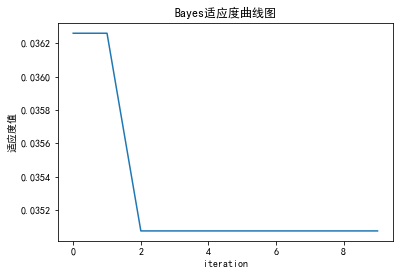

In [19]:
    plt.rcParams['font.sans-serif'] = ['SimHei'] #防止中文乱码
    plt.rcParams['axes.unicode_minus']=False
    plt.figure()
    plt.plot(trace)
    plt.xlabel('iteration')
    plt.ylabel('适应度值')
    plt.title("Bayes适应度曲线图")
#     plt.savefig('Bayes适应度曲线.png')
    plt.show()

In [35]:
result = np.array(result)

In [36]:
result=result[-1:,:].reshape(-1,)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [39]:
def build_model1(result):
    inputs = Input(train1.shape[-3:])
    
    x=Attention_Conv2D(1, activation='relu', num_heads=int(result['mul_head']), return_attention_scores=True)(inputs)
    x=Dropout(0.1)(x)
    x = Conv2D(int(result['cnn_layers']), (3,5), padding="same",activation="relu")(inputs)  #, padding = 'same'
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)    

    lstm_out = Dense(10,activation="relu")(x) 
    attention_mul = Flatten()(lstm_out)


    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=[output])
    model.compile(optimizer=tf.keras.optimizers.Adam(result['lr'], beta_1=0.5),#学习率  learning rate
                  loss="mean_squared_error")#回归问题，损失函数使用均方误差  Regression problem, loss function using mean square error
    
    return model

In [40]:
model = build_model1(result)

In [41]:
model.summary()

Model: "model_111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_117 (InputLayer)       [(None, 3, 5, 1)]         0         
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 3, 5, 27)          432       
_________________________________________________________________
dropout_225 (Dropout)        (None, 3, 5, 27)          0         
_________________________________________________________________
batch_normalization_221 (Bat (None, 3, 5, 27)          108       
_________________________________________________________________
dense_222 (Dense)            (None, 3, 5, 10)          280       
_________________________________________________________________
flatten_111 (Flatten)        (None, 150)               0         
_________________________________________________________________
dense_223 (Dense)            (None, 1)                 15

In [45]:
history = model.fit(train_batch_dataset,
                    epochs=result['epochs'],
                    validation_data=test_batch_dataset)

Epoch 1/27
35/35 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 2/27
35/35 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 3/27
35/35 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 4/27
35/35 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 5/27
35/35 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 6/27
35/35 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 7/27
35/35 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 8/27
35/35 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 9/27
35/35 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 10/27
35/35 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 11/27
35/35 [

In [46]:
pred = model.predict(train1)

In [47]:
score1=r2_score(train_labels,pred)
print('r^2值为：',score1)

r^2值为： 0.9398536638589423
